In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as img
import panel as pn
import itertools
import math

pn.extension()

In [2]:
image_dir = Path("../images")
files = list(image_dir.rglob("*.png"))
files[10:13]

[PosixPath('../images/SiO3+0002-03-16 12:00:00+z_t@500.0.png'),
 PosixPath('../images/SiO3+0004-01-16 12:00:00+log_10@True+z_t@500.0.png'),
 PosixPath('../images/PO4+0001-02-15 00:00:00+z_t@35109.34765625.png')]

In [3]:
entries = []
for file in files:
    path = file.as_posix()
    if "checkpoint" in path:
        continue
    parts = file.stem.split("+")
    x = dict(varname=parts[0], time=parts[1], path=path)
    if len(parts) > 2:
        for part in parts[2:]:
            y = part.split("@")
            x[y[0]] = y[1]
            if y[0].startswith("z_t"):
                x["depth_level"] = y[1]
    entries.append(x)

df = pd.DataFrame(entries)

df["z_t"] = df["z_t"].astype(float)
df["z_t_150m"] = df["z_t_150m"].astype(float)
df["depth_level"] = df["depth_level"].astype(float)
df["depth_level"] = df["depth_level"].fillna(-9999)
df["log_10"] = df.log_10.map(lambda x: True if x == "True" else False)

grouped = df.groupby(["varname", "time", "depth_level", "log_10"])
df.head()

varname                 time  \
0  photoC_cocco_zint  0004-02-15 00:00:00   
1   photoC_diat_zint  0002-12-16 12:00:00   
2      O2_ZMIN_DEPTH  0004-04-16 00:00:00   
3            diatChl  0002-05-16 12:00:00   
4    CaCO3_FLUX_100m  0001-08-16 12:00:00   

                                                path  z_t_150m  depth_level  \
0  ../images/photoC_cocco_zint+0004-02-15 00:00:0...       NaN      -9999.0   
1  ../images/photoC_diat_zint+0002-12-16 12:00:00...       NaN      -9999.0   
2    ../images/O2_ZMIN_DEPTH+0004-04-16 00:00:00.png       NaN      -9999.0   
3  ../images/diatChl+0002-05-16 12:00:00+z_t_150m...     500.0        500.0   
4  ../images/CaCO3_FLUX_100m+0001-08-16 12:00:00+...       NaN      -9999.0   

   log_10  z_t  
0   False  NaN  
1   False  NaN  
2   False  NaN  
3   False  NaN  
4    True  NaN

In [4]:
def render_images(variables, times, depth_levels, log_10):
    if isinstance(variables, str):
        variables = [variables]
    if isinstance(times, str):
        times = [times]

    keys = list(
        itertools.product(*[variables, times, [depth_levels], [log_10]])
    )

    images_data = []
    for key in keys:
        try:
            df = grouped.get_group(key)
            path = df.iloc[0].path
            varname = df.iloc[0].varname
            data = img.imread(path)
            images_data.append([varname, data])
        except KeyError:
            pass
    if images_data:
        if len(images_data) < 2:
            ncols = 1
        elif len(images_data) >= 2 and len(images_data) <= 4:
            ncols = 2

        elif len(images_data) > 4 and len(images_data) <= 9:
            ncols = 3

        elif len(images_data) > 9 and len(images_data) <= 16:
            ncols = 4

        elif len(images_data) > 16 and len(images_data) <= 25:
            ncols = 5

        else:
            ncols = 6

        nrows = math.ceil(len(images_data) / ncols)

        fig, axes = plt.subplots(
            nrows=nrows, ncols=ncols, figsize=(18, 10), squeeze=False
        )
        for data, ax in zip(images_data, axes.flat):
            ax.imshow(data[1])
            ax.axis("off")
            # ax.set_title(f"{data[0]}")

        empty_subplot_indices = set(range(len(axes.flat))) - set(
            range(len(images_data))
        )
        if empty_subplot_indices:
            for index in empty_subplot_indices:
                fig.delaxes(axes.flatten()[index])
        plt.tight_layout()
        plt.close(fig)
        return fig

In [5]:
variables = pn.widgets.CheckBoxGroup(
    name="Variable",
    value=["CaCO3_FLUX_100m"],
    options=sorted(list(df.varname.unique())),
)
times = pn.widgets.Select(name="Time", options=sorted(list(df.time.unique())))
log_10 = pn.widgets.Checkbox(name="log_10", value=False)
depth_levels = pn.widgets.Select(
    name="Depth Level (z-level)", options=sorted(list(df.depth_level.unique()))
)


@pn.depends(variables, times, depth_levels, log_10)
def viewer(variables, times, depth_levels, log_10):
    return render_images(variables, times, depth_levels, log_10)


controls = pn.Column(variables, log_10, times, depth_levels)
v = pn.Row(controls, viewer)
text = "<br>\n# Image Viewer\n**Select variables, depth level, and time step**"
p = pn.Row(
    pn.Column(
        text,
        "Variable",
        v[0][0],
        "Apply Log base 10",
        v[0][1],
        v[0][2],
        v[0][3],
        width=200,
    ),
    pn.Column(v[1][0]),
)

In [6]:
variables_b = pn.widgets.Select(
    name="Variable",
    value="CaCO3_FLUX_100m",
    options=sorted(list(df.varname.unique())),
)
times_b = pn.widgets.CheckBoxGroup(
    name="Time",
    value=["0001-01-16 12:15:50"],
    options=sorted(list(df.time.unique())),
)


@pn.depends(variables_b, times_b, depth_levels, log_10)
def viewer_b(variables_b, times_b, depth_levels, log_10):
    return render_images(variables_b, times_b, depth_levels, log_10)


controls_b = pn.Column(variables_b, log_10, times_b, depth_levels)
v_b = pn.Row(controls_b, viewer_b)
p_b = pn.Row(
    pn.Column(
        text,
        v_b[0][0],
        "Apply Log Base 10",
        v_b[0][1],
        "Time",
        v_b[0][2],
        v_b[0][3],
        width=200,
    ),
    pn.Column(v_b[1][0]),
)

Tabs
    [0] Row
        [0] Column(width=200)
            [0] Markdown(str)
            [1] Markdown(str)
            [2] CheckBoxGroup(name='Variable', options=['CaCO3_FLUX_100m', ...], value=['CaCO3_FLUX_100m'])
            [3] Markdown(str)
            [4] Checkbox(name='log_10')
            [5] Select(name='Time', options=['0001-01-16 12:15:50', ...], value='0001-01-16 12:15:50')
            [6] Select(name='Depth Level (z-level)', options=[-9999.0, 500.0, ...], value=-9999.0)
        [1] Column
            [0] ParamFunction(function)
    [1] Row
        [0] Column(width=200)
            [0] Markdown(str)
            [1] Select(name='Variable', options=['CaCO3_FLUX_100m', ...], value='CaCO3_FLUX_100m')
            [2] Markdown(str)
            [3] Checkbox(name='log_10')
            [4] Markdown(str)
            [5] CheckBoxGroup(name='Time', options=['0001-01-16 12:15:50', ...], value=['0001-01-16 12:15:50'])
            [6] Select(name='Depth Level (z-level)', options=[-9999.0, 500.0, ...], value=-9999.0)
        [1] Column
            [0] ParamFunction(function)
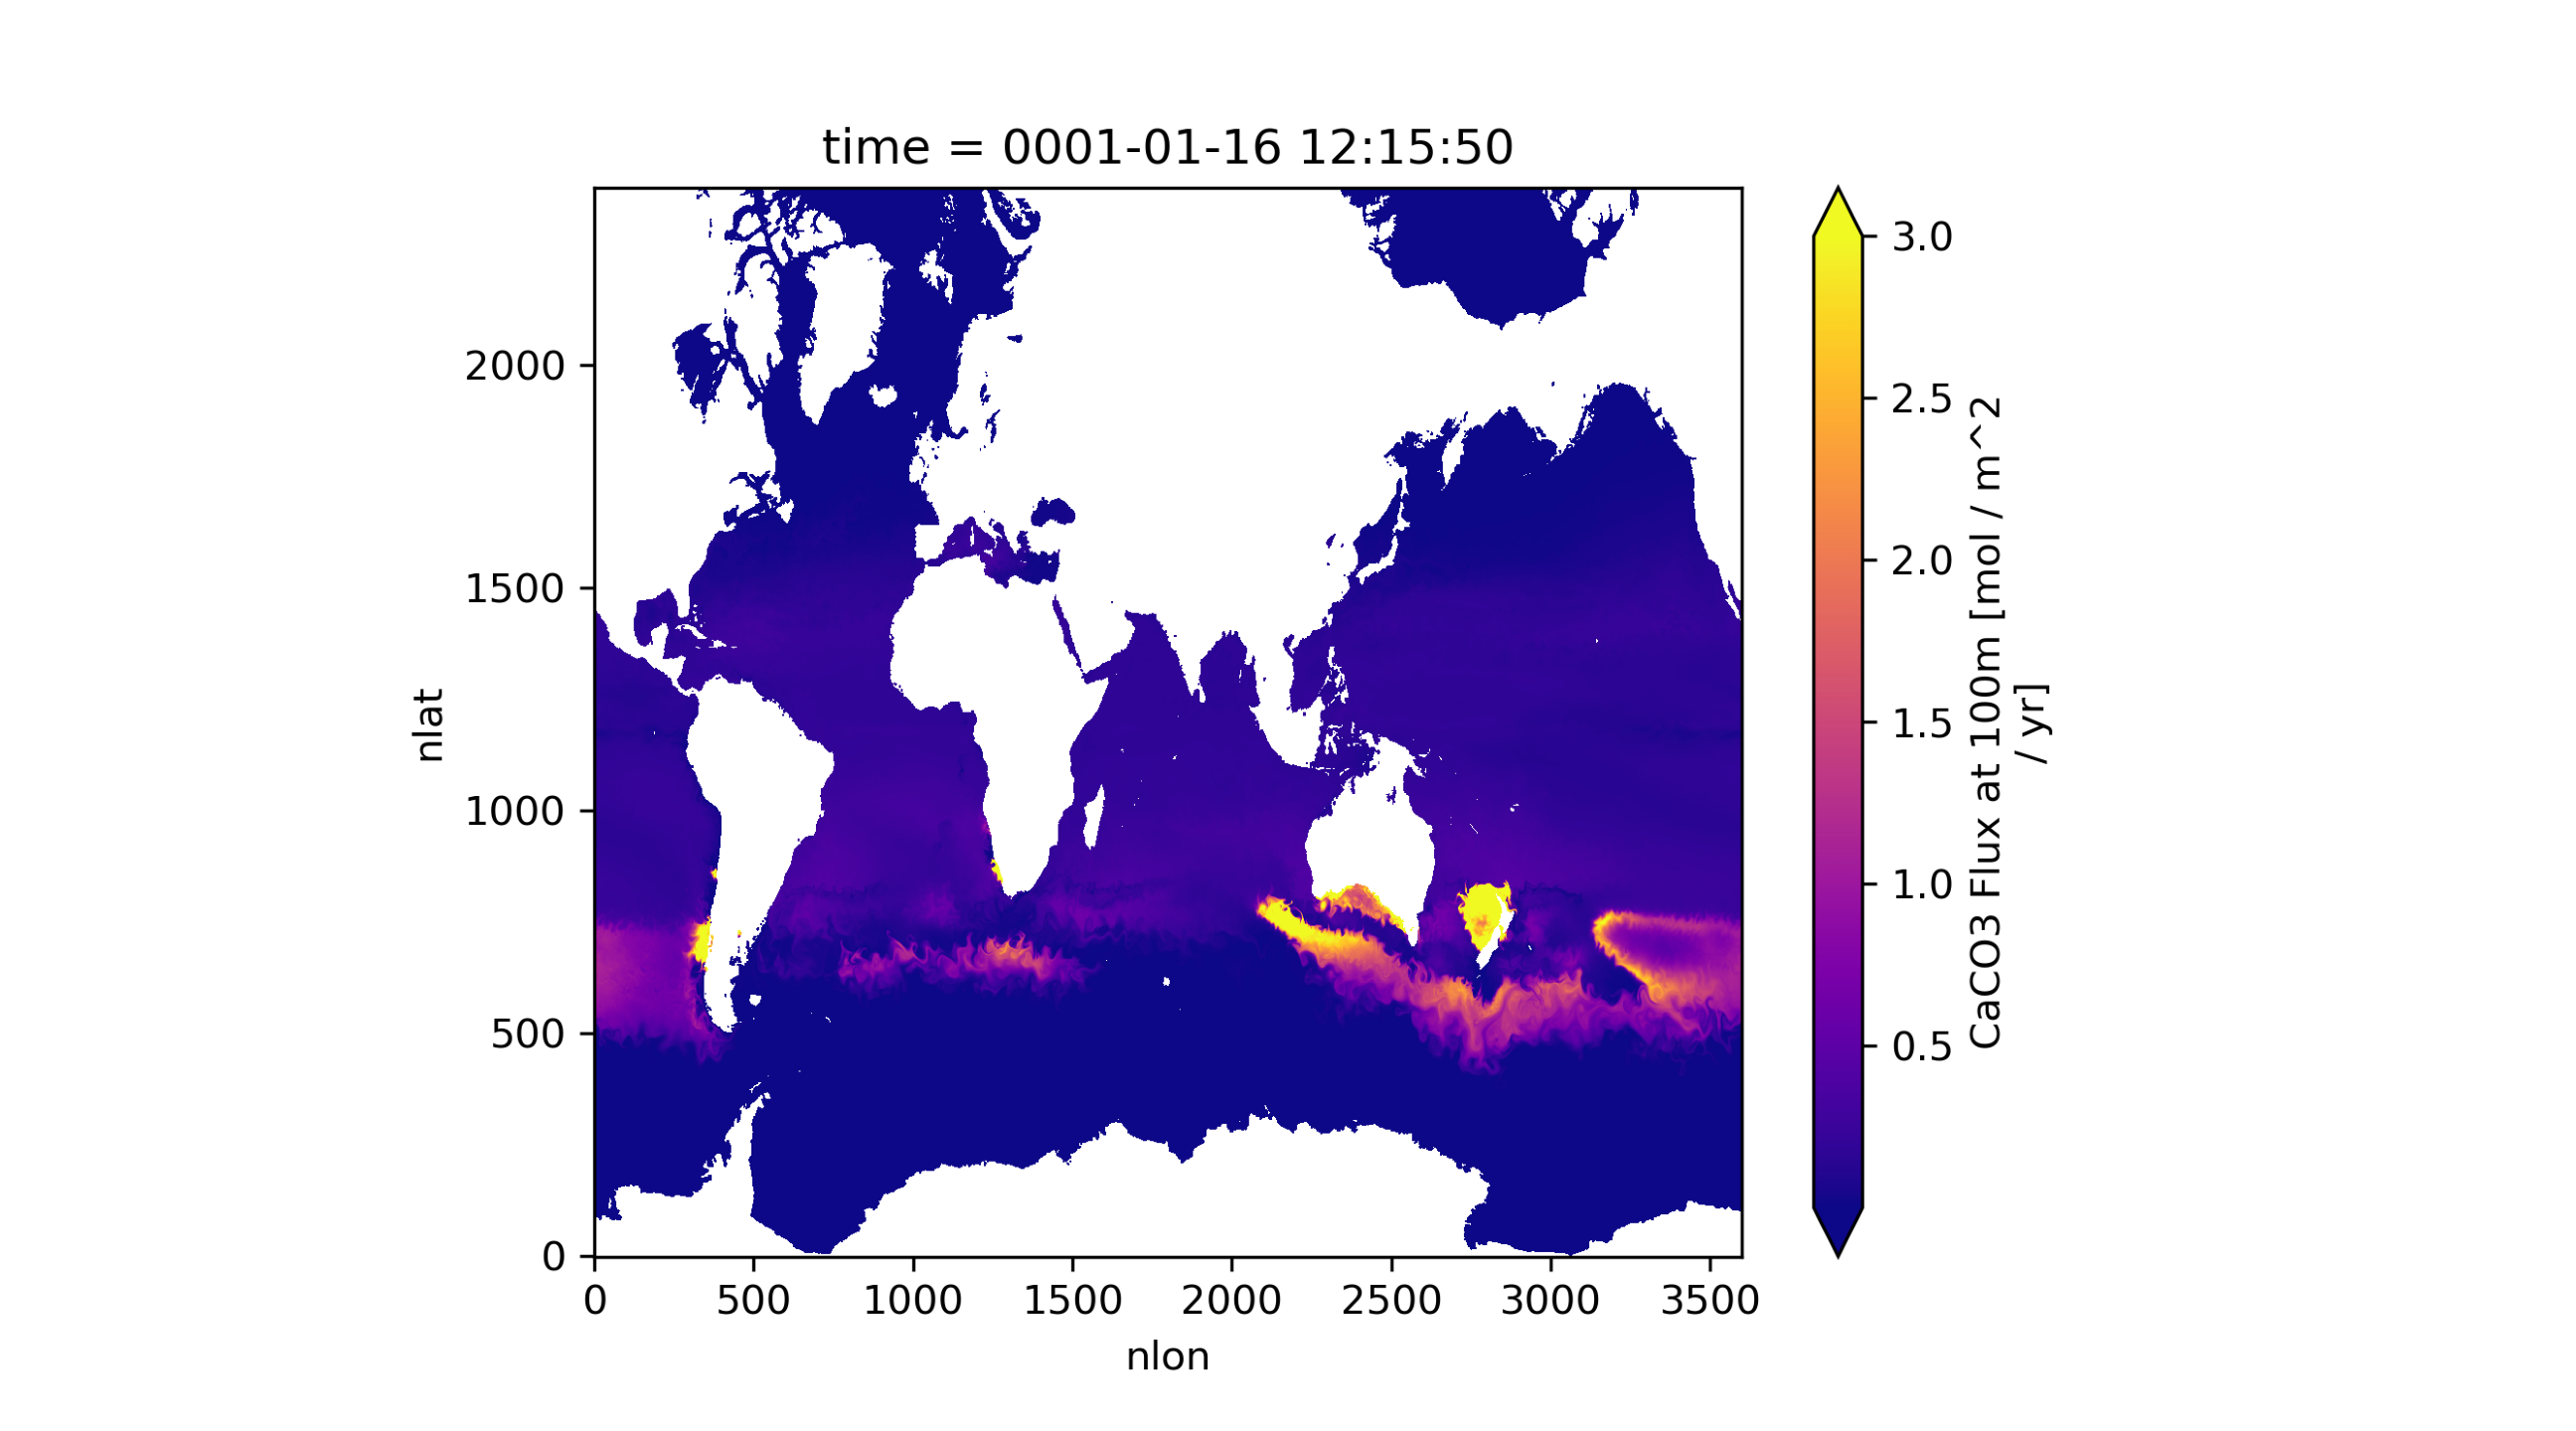
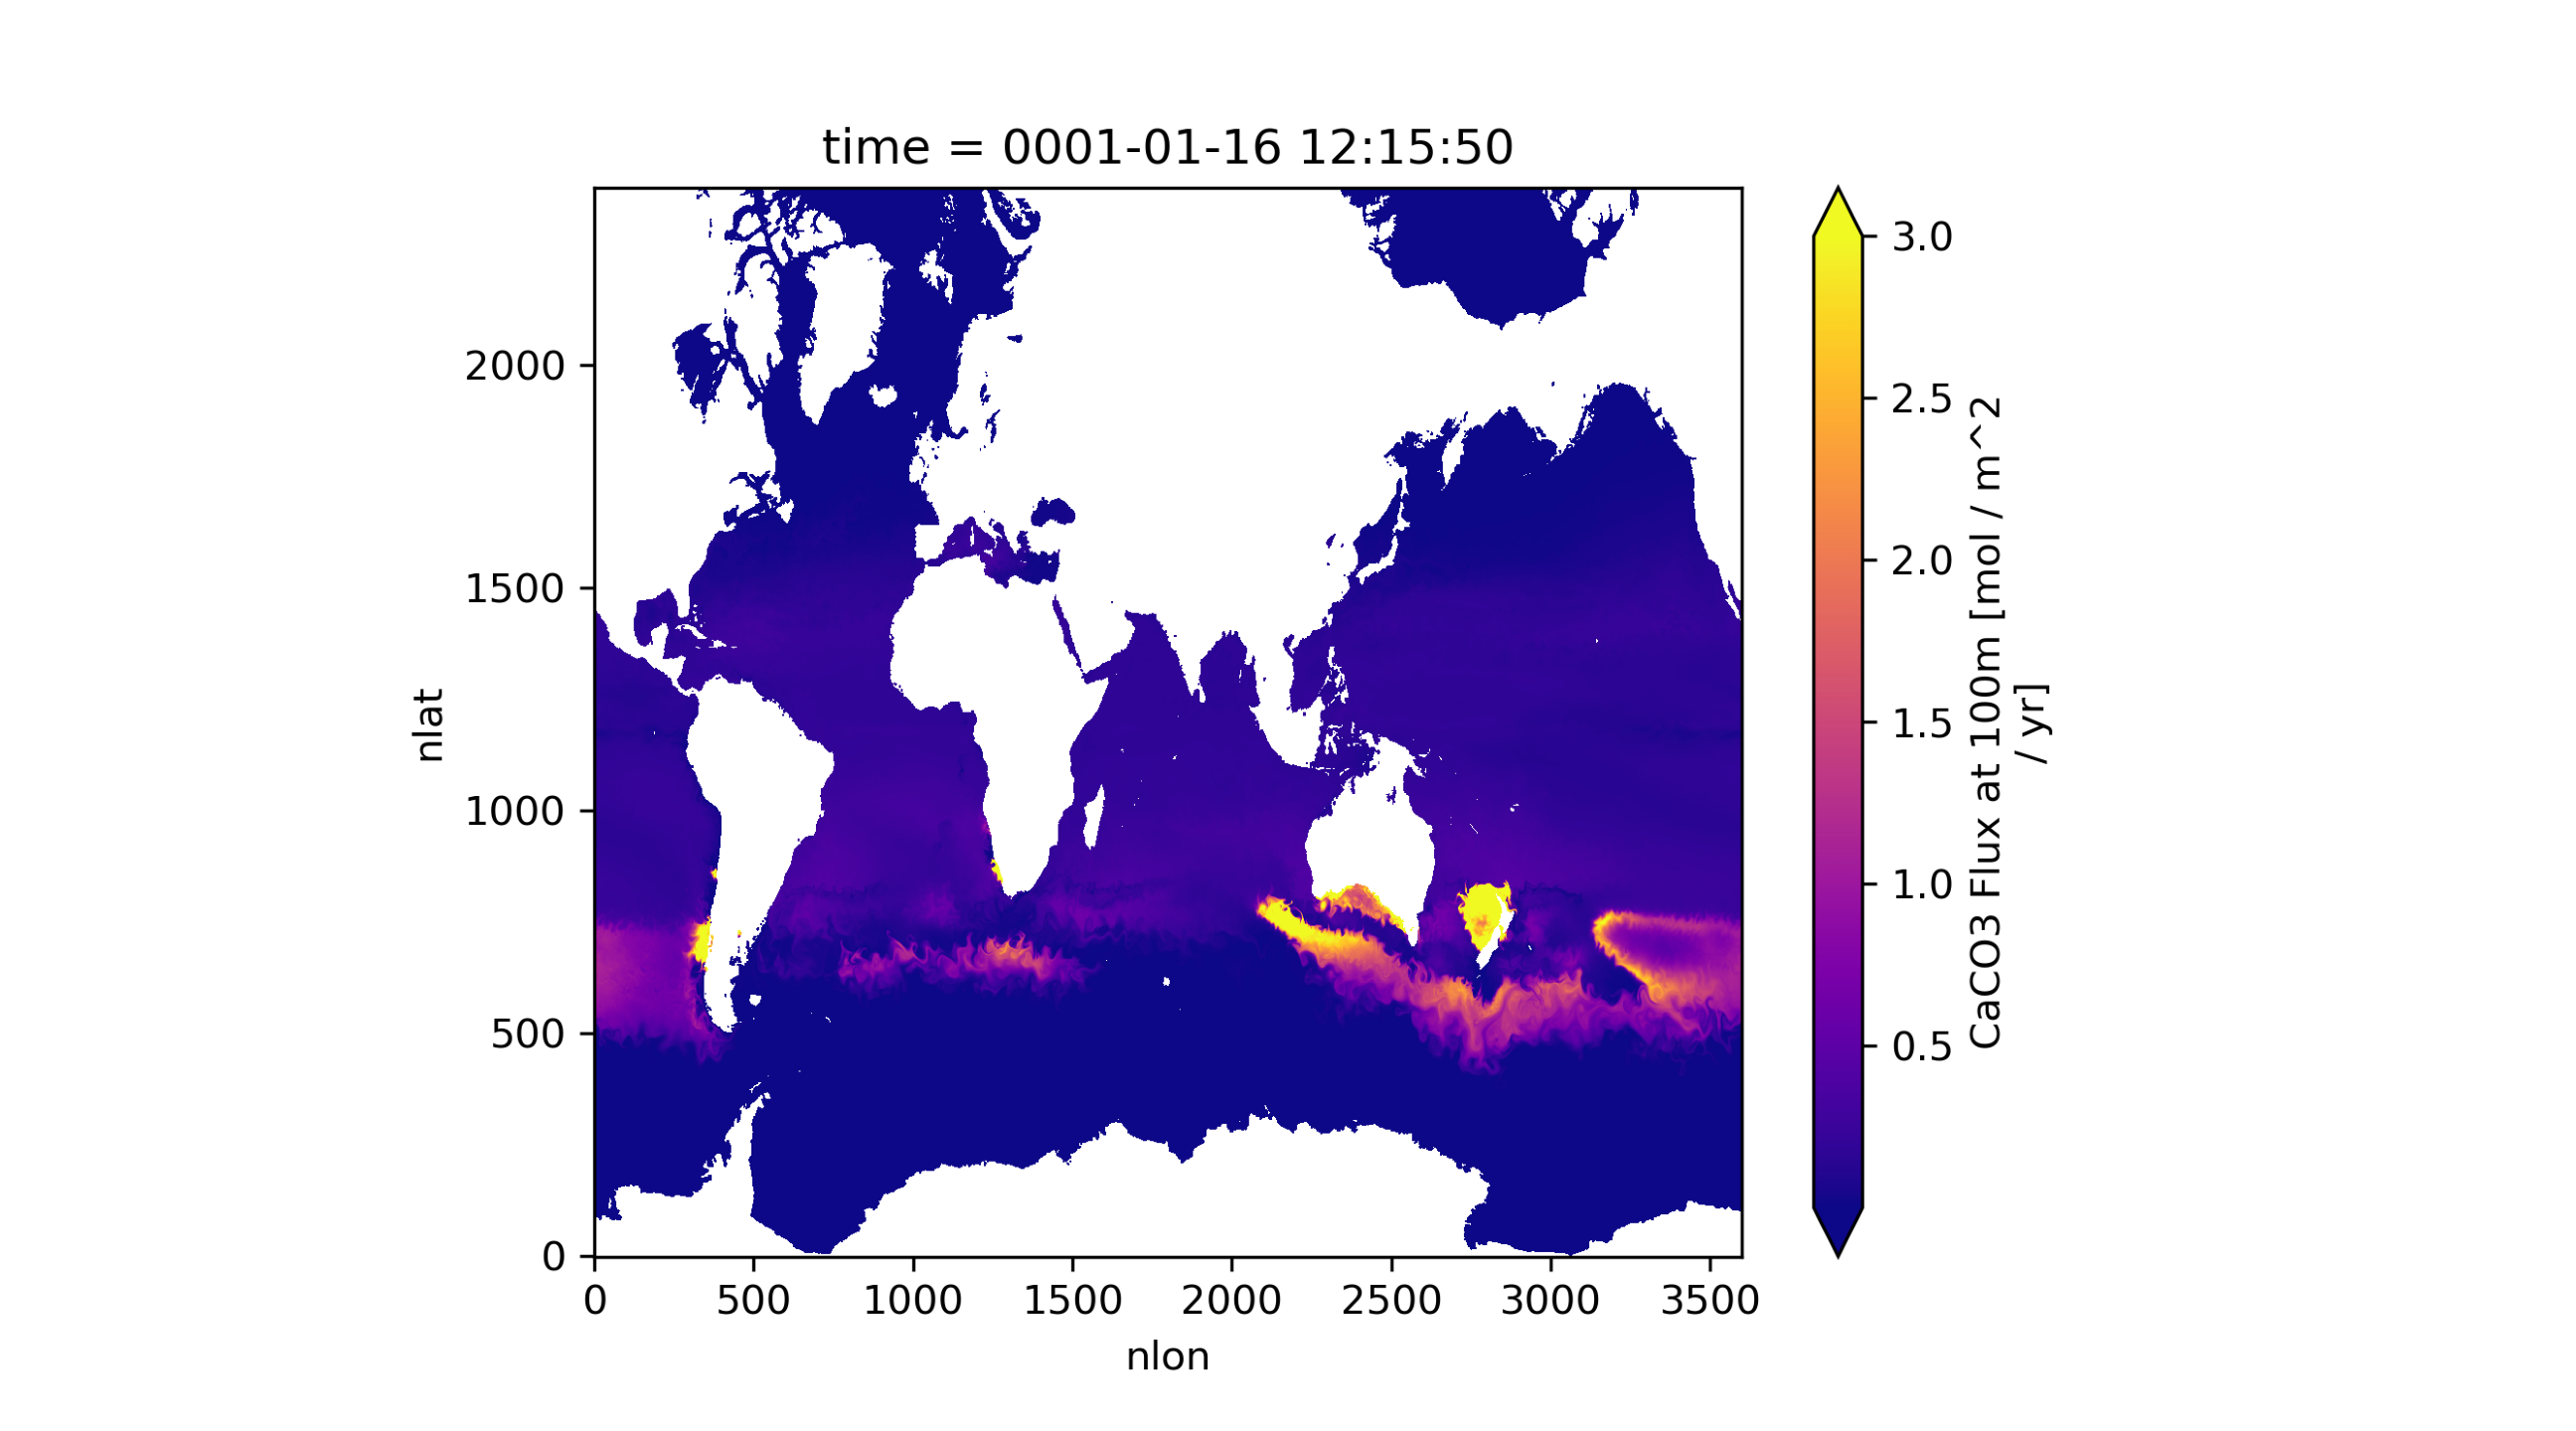

In [7]:
tabs = pn.Tabs(("Multi Variables View", p), ("Multi Time-steps View", p_b))
tabs